In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import Tuple, List, Dict

In [2]:
#%cd 'drive/My Drive/Colab Notebooks/LAMFO/scripts'

/content/drive/My Drive/Colab Notebooks/LAMFO/scripts


In [3]:
def load_data():
  data_dict = {}
  data_dict['monthly'] = pd.read_csv('../data_processed/monthly.csv',index_col='Date',parse_dates=True)
  data_dict['quarterly'] = pd.read_csv('../data_processed/quarterly.csv',index_col='Date',parse_dates=True)
  data_dict['daily'] = pd.read_csv('../data_processed/daily.csv',index_col='Unnamed: 0',parse_dates=True)
  y = data_dict['quarterly'].shift(-1)
  

  return data_dict, y


def split_data(
    X:Dict[str,pd.DataFrame],
    y:pd.DataFrame, end_train:int
    )->Tuple[Dict[str,pd.DataFrame],pd.DataFrame]:
  train_dict = {}
  test_dict = {}
  for freq, indicators in X.items():
    train_dict[freq] = indicators.iloc[:end_train,:]
    test_dict[freq] = indicators.iloc[end_train+1:,:]
  train_dict['target'] = y.iloc[:end_train,:]
  test_dict['target'] = y.iloc[end_train+1,:]
  
  return train_dict,test_dict
  


In [57]:
class Net(nn.Module):
    def __init__(self,daily_dim,monthly_dim,quarterly_dim,out_dim = 10):    
    	# Define all the parameters of the net
        super(Net, self).__init__()
        daily_out = daily_dim//90
        monthly_out = monthly_dim//3
        self.fc_daily = nn.Linear(daily_dim, daily_out)
        self.fc_monthly = nn.Linear(monthly_dim, monthly_out)
        self.fc_quarterly = nn.Linear(quarterly_dim, quarterly_dim)
        self.fc_merge = nn.Linear(daily_out+monthly_out+quarterly_dim,out_dim)
        self.fc_out = nn.Linear(out_dim,1)

    def forward(self, X):   
    	# Do the forward pass

        daily,monthly,quarterly = X
        daily = F.relu(self.fc_daily(daily))
        monthly = F.relu(self.fc_monthly(monthly))
        quarterly = F.relu(self.fc_quarterly(quarterly))

        x = torch.cat([daily,monthly,quarterly],axis=-1)

        x = F.relu(self.fc_merge(x))
        x = self.fc_out(x)
        return x

In [18]:
data_dict, y = load_data()

In [19]:
end_train = 145
train_data,test_data = split_data(data_dict,y,end_train)

In [20]:
X_daily_train = torch.tensor(train_data['daily'].values,dtype=torch.float).cuda()
X_monthly_train = torch.tensor(train_data['monthly'].values,dtype=torch.float).cuda()
X_quarterly_train = torch.tensor(train_data['quarterly'].values,dtype=torch.float).cuda()
y_train = torch.tensor(train_data['target'].values,dtype=torch.float).cuda()

X_daily_test = torch.tensor(test_data['daily'].values,dtype=torch.float).cuda()
X_monthly_test = torch.tensor(test_data['monthly'].values,dtype=torch.float).cuda()
X_quarterly_test = torch.tensor(test_data['quarterly'].values,dtype=torch.float).cuda()
y_test = torch.tensor(test_data['target'].values,dtype=torch.float).cuda()

In [60]:
daily_dim = X_daily_train.shape[1]
monthly_dim = X_monthly_train.shape[1]
quarterly_dim = X_quarterly_train.shape[1]
model = Net(daily_dim,monthly_dim,quarterly_dim)   
optimizer = optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.MSELoss()
model.cuda()

Net(
  (fc_daily): Linear(in_features=90, out_features=1, bias=True)
  (fc_monthly): Linear(in_features=12, out_features=4, bias=True)
  (fc_quarterly): Linear(in_features=1, out_features=1, bias=True)
  (fc_merge): Linear(in_features=6, out_features=10, bias=True)
  (fc_out): Linear(in_features=10, out_features=1, bias=True)
)

In [64]:

train_loss = []
test_loss = []
accuracy_plot = []
n_epochs = 20
for epoch in range(n_epochs):
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for t in range(end_train):
        X = (X_daily_train[t,:],X_monthly_train[t,:],X_quarterly_train[t,:])
        # Predict/Forward Pass
        y_pred = model(X)
        y_true = y_train[t]
        # Compute loss
        loss = loss_fn(y_pred, y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss+=loss.item()
    train_loss.append(avg_loss/end_train)
    model.eval()        
    avg_test_loss = 0.
    for t in range(y_test.shape[0]):
        X = (X_daily_test[t,:],X_monthly_test[t,:],X_quarterly_test[t,:])
        y_pred = model(X).detach()
        y_true = y_train[t]
        avg_test_loss += loss_fn(y_pred,y_true).item()
    test_loss.append(avg_test_loss/y_test.shape[0])    

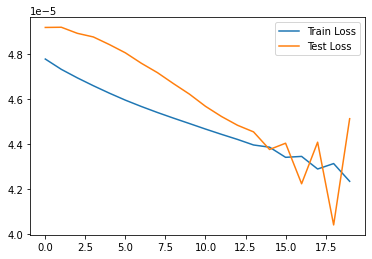

In [72]:
plt.plot(np.array(train_loss),label='Train Loss')
plt.plot(np.array(test_loss),label='Test Loss')
plt.legend()
plt.show()